# Part 5 - University of Michigan Consumer Sentiment data

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

### I think they do a great job of documentation at the [site](https://data.sca.isr.umich.edu/survey-info.php).
Also have a look at the [siki page](https://en.wikipedia.org/wiki/University_of_Michigan_Consumer_Sentiment_Index) about the survey and the data. In particular the references to [this](https://www.wsj.com/articles/university-of-michigan-inks-deal-to-end-early-release-of-survey-1412690643) and indirectly [this](https://www.wsj.com/articles/SB10001424127887324682204578515963191421602) about Thomson Reuters and others giving investors early access for a fee.

In any case, you can see the question asking [sheet](https://data.sca.isr.umich.edu/fetchdoc.php?docid=24776) and more.
I am interested in the responses about expectations.
There seems like a lot of great information there but I am going to focus on the data on the components of the index and in particular the 3 questions related to expectations
* x2= PEXP_R = "Now looking ahead--do you think that a year from now you (and your family living
there) will be better off financially, or worse off, or just about the same as now?"
* x3= BUS12_R = "Now turning to business conditions in the country as a whole--do you think that
during the next twelve months we'll have good times financially, or bad times, or
what?"
* x4= BUS5_R = "Looking ahead, which would you say is more likely--that in the country as a whole
we'll have continuous good times during the next five years or so, or that we will
have periods of widespread unemployment or depression, or what?"

They compute a weighted average called the Index of Consumer Expectations, or ICE, as follows

ICE = ((x2 + x3 + x4)/4.1134) + 2
<sup>[1](#myfootnote1)</sup>

I'm sure somewhere in the documentation they explain why they divide by 4.1134 and add 2 but I'll probably just use the 3 individual variables.  We'll see.

<a name="myfootnote1">1</a>: Notice I put in the parentesis to avoid issues like [this](https://www.nytimes.com/2019/08/02/science/math-equation-pedmas-bemdas-bedmas.html#:~:text=To%20help%20students%20in%20the,%2C%20division%2C%20addition%2C%20subtraction).
If the link doesn't work search for "The Math equation that stumped the internet")


First the bolerplate Python I use for most notebooks.  It's evolving.

In [1]:
import os
import sys
import datetime
import time
import re
import inspect
import pandas as pd
from plotnine import ggplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import pathlib

I like to see version numbers for modules ... and for Python.

In [2]:
mlist = list(filter(lambda x: inspect.ismodule(x[1]), locals().items()))
vi = sys.version_info
print("version {0}.{1}.{2} of Python".format(vi.major, vi.minor, vi.micro))
for name, mod in mlist:
    if name.startswith("__"):
        continue
    if hasattr(mod, "__version__"):
        print("version {1} of {0}".format(name, mod.__version__))
del mod
del name

version 3.8.5 of Python
version 2.2.1 of re
version 1.1.3 of pd
version 3.3.3 of mpl
version 3.141.0 of selenium
version 3.14.1 of webdriver


## Selenium to automate downloading
It's easy to get the data from the site, can be done via the following steps.
1. Navigate to https://data.sca.isr.umich.edu/data-archive/mine.php
<sup>[2](#myfootnote1)</sup>
2. For **Table** select **Table 5: Components of the Index of Consumer Sentiment**.
3. Click **Comma-Separated(CSV)** under format and it should start downloading.

But I want to automate the process and we will using Selenium. 
Selenium allows us to control a web browser from Pyhon so I can use Python to execute all the steps above.

<a name="myfootnote1">2</a>: Note that if you start at the main site you might need to click on **Data** and select *Time Series* in the dropdown.

## Download Directory
I want to have the data downloaded into a subdirectory below here rather than the default *Downloads* directory.
We can arrange that using ChromeOptions.

In [3]:
temp_dir = "./data/temp"
if not os.path.isdir(temp_dir):
    os.mkdir(temp_dir)
prefs = {"download.default_directory" : os.path.abspath(temp_dir)}

options = webdriver.ChromeOptions()
options.add_experimental_option("prefs",prefs)
options.add_argument("download.default_directory="+os.path.abspath(temp_dir))

## Step 1, going to the site
You can run Selenium in what is called *headless* mode where you don't get a window for the browser.
But I still find it cool to see a new browser pop up so I won't use that now.
And it's nice in the early stages to see what is actually happening.
Probably will change once the novelty wears off.

### chromedriver
With Selenium you have a choice of which browser to use, e.g. Chrome, Firefox et cetera.  I'll use Chrome.  Whatever the choice we'll need a *driver*.  Google it if you are interested.
I downloaded the chromedriver and put it in a sibling directory under *chromedriver_win32* so it is easy to find for others projects using Selenium.

Here I am doing step 1 from above.

In [4]:
chromedriver_path = os.path.join('chromedriver.exe')
driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
url = "https://data.sca.isr.umich.edu/data-archive/mine.php"
driver.get(url)

## Step 2: selecting Table 5
There are plenty of tutorials on using Selenium to make selections and click buttons.
I can't remember which ones I used. Most likely I just googled what I wanted to do.

In any case, here I am finding the selection section on the page and choosing option 5.

In [18]:
# Locate the Sector and create a Select object
select_element = Select(driver.find_element_by_css_selector("select"))
# this will print out strings available for selection on select_element, used in visible text below
select_element.select_by_index(5)

### Identifying the newly downloaded file
In the final step I will download a file with the data into the *./data* directory.  But I don't know exactly what the file name will be yet, and also if I pull it down multiple times the file will get names lik "file.csv", "file(2).csv" et cetera.  I want to make sure I can idendify the the latest one I downloaded.  I wrote the function below to help with that.  It is pobably way more complicated than it needs to be.

In any case, the idea is to start with a list of all the files in the directory *before* I asked for the download.
Then, I look for new files with the appropriate extension, in this case ".csv".  Once I find a file that was not there before, that is the one that just got donloaded.  In case the file takes some time to download I will loop looking for a new file,  but I have a limit on how long I will do this looping, My default wait limit is 10 seconds.  

In [19]:
def get_downloaded_fpath(dir=None, files_before=None, file_ext=".csv",
                   max_wait = 10, verbose=True):
    import time
    done = False
    start_time = datetime.datetime.now()
    while not done:
        files_after = set(os.listdir(dir))
        new_files = files_after.difference(set(files_before))
        print(new_files)
        for fname in new_files:
            if os.path.splitext(fname)[1] == file_ext:
                return (os.path.join(dir, fname))
        cur_time = datetime.datetime.now()
        if (cur_time - start_time).seconds > 10:
            return None
        time.sleep(0.5)

## Step 3: Selecting *Comma-Separated(CSV)*
Now I look for the "Comma-Separated(CSV)" button on the web page and *click* it.
Then I use the above function to find the path to the new file.

In [20]:
elements = driver.find_elements_by_name("format")
button = None
for e in elements:
    if e.get_property("value") == 'Comma-Separated (CSV)':
        button = e
        break
if not button:
    raise RuntimeError("Error downloading Consumer Sentiment data from {0}".format(url))
            
files_before = set(os.listdir(temp_dir))
button.click()
fpath = get_downloaded_fpath(dir=temp_dir, files_before=files_before, file_ext=".csv", max_wait=10)
if not fpath:
    raise Exception("No downloaded file found!")
print("new file: {0}".format(fpath))

set()
set()
{'6cdd26b7-050f-47a5-b417-90b22b5c0fe5.tmp'}
{'sca-table5-on-2020-Nov-12.csv'}
new file: ./data/temp\sca-table5-on-2020-Nov-12.csv


Shotdown the browser 

In [21]:
driver.quit()

* Read in the new file
* print the volumns
* Drop the last column, don't know what it is
* Make a *datetime* column from the month and year and drop the month and year columns.
* make the datetime column the index
* pick out th expectation columns as the ones that have either "expected" or "Business Condition" in the name.
 - drop all but the expected columns


In [22]:
df = pd.read_csv(fpath, skiprows=1)
print(df.columns)
df.drop(df.columns[-1], inplace=True, axis=1)
df['Datetime'] = (100*100*df['Year'] + 100*df["Month"] + 15).astype(str)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.drop(["Month", "Year"],  inplace=True, axis=1)
df.set_index("Datetime", inplace=True)
exp_columns = [c for c in df.columns if re.search("Expected|Business Condition", c)]
df = df[exp_columns]
df.head()

Index(['Month', 'Year', 'Personal Finance Current',
       'Personal Finance Expected', 'Business Condition 12 Months',
       'Business Condition 5 Years', 'Buying Conditions', 'Current Index',
       'Expected Index', 'Unnamed: 9'],
      dtype='object')


,Personal Finance Expected,Business Condition 12 Months,Business Condition 5 Years,Expected Index
Datetime,,,,
2008-01-15,116,68,88,68.1
2008-02-15,112,54,83,62.4
2008-03-15,112,46,81,60.1
2008-04-15,100,40,71,53.3
2008-05-15,98,36,68,51.1


Plot all the *expected* series

(0.0, 142.3)

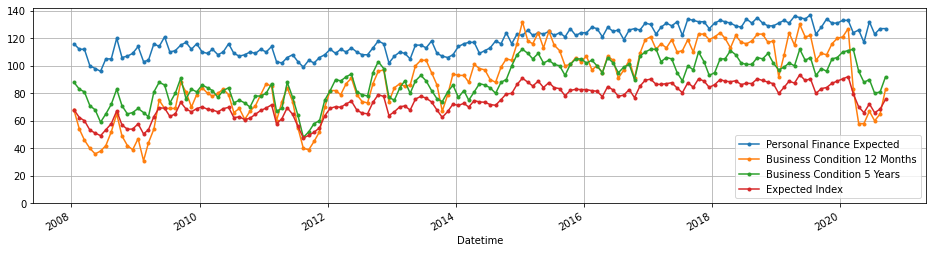

In [23]:
df.plot(figsize=[16,4], marker='.', grid=True)
plt.gca().set_ylim(bottom=0)

Save the dataframe as "umich_exp.csv"

In [24]:
try:
    out_dir = "./data"
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    df.to_csv(os.path.join(out_dir, "umich_exp.csv"))
except Exception as exc:
    print(exc)
    raise Exception(exc)

* delete all the files in the temp directory
* delete the temp directory

In [25]:
try:
    if os.path.isdir(temp_dir):
        temp_files = os.listdir(temp_dir)
        # remove all the temp files
        for tfile in temp_files:
            os.remove(os.path.join(temp_dir, tfile))
    # remove the temp_dir
    if os.path.isdir(temp_dir):
        pathlib.Path.rmdir(pathlib.Path(temp_dir))
except Exception as exc:
    print(exc)
    raise Exception(exc)

In [26]:
import datetime
print(datetime.datetime.now())

2020-11-12 07:08:31.238145
